In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import torch
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

In [21]:
df = pd.read_csv('../data/edges.csv')
df

,Customer,Supplier
0,Volvo,AAPICO Hitech
1,Volvo,ABC Technologies
2,Volvo,Adient plc
3,Volvo,AGC
4,Volvo,Aisin
...,...,...
51358,Unipres,voestalpine Rotec
51359,Unipres,Xiangyang Sunrise
51360,Unipres,Yakumo Manufacturing
51361,Unipres,Yamashita Rubber


In [22]:
all_suppliers = set(df['Customer'].tolist() + df['Supplier'].tolist())

In [23]:
len(all_suppliers)

15027

In [24]:
nametoi = {name: i for i, name in enumerate(all_suppliers)}
edges = []

for _, row in df.iterrows():
    supplier1, supplier2 = row
    idx1, idx2 = nametoi[supplier1], nametoi[supplier2]
    edges.append((idx1, idx2))

In [25]:
# Create the graph
G = nx.Graph()
G.add_edges_from(edges)

In [7]:
nx.diameter(G)

6

In [26]:
# get the distances between all node pairs
distances = dict(nx.all_pairs_shortest_path_length(G))

In [27]:
distance_pairs = {}
for node1, nbs in distances.items():
    for node2, distance in nbs.items():
        distance_pairs[(min(node1, node2), max(node1, node2))] = distance

In [28]:
torch.save(distance_pairs, '../data/distance_pairs.pt')

(array([1.5027000e+04, 4.8261000e+04, 0.0000000e+00, 1.1527360e+07,
        0.0000000e+00, 5.9811289e+07, 4.0057711e+07, 0.0000000e+00,
        1.4525600e+06, 6.7000000e+02]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

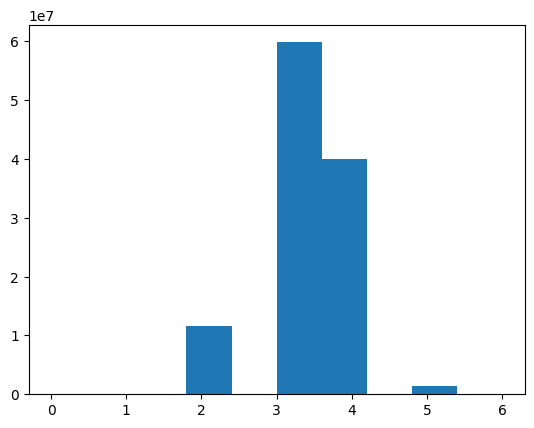

In [30]:
plt.hist(distance_pairs.values())

In [29]:
pos, neg = [], []

for pair, distance in distance_pairs.items():
    if distance == 1:
        pos.append(pair)
    if distance > 1:
        neg.append(pair)

In [30]:
print(f'There are {len(pos):,} positive edges, and {len(neg):,} negative edges')

There are 48,261 positive edges, and 112,849,590 negative edges


In the paper, the authors trained the model with $1:1$ link/non-link ratio, and these ratios for test are $1:1/2/3/4$.

Therefore, we will need $24,130$ positive samples and the same amount in negative samples for training.

For testing, we need $24,130$ positive samples, and $24,130*4=96,520$ negative samples.

In total, we will need $24,130*4=120,650$ negative samples.

In [38]:
POSITIVE_SIZE = 24_130

In [39]:
neg_subset = neg[::len(neg)//(POSITIVE_SIZE*5)][:POSITIVE_SIZE*5]
len(neg_subset)

120650

According to the paper, each node will be assigned a color using this formula:

$$
f_{l}(i) = 1 + \min(d_x, d_y) + \frac{d}{2} \left[\frac{d}{2} + (d \% 2) - 1 \right]
$$

where *i* is a neighbouring node, *x* and *y* are the pair of nodes under consideration, $d_x$ and $d_y$ are shortest paths between *i* and *x*, *y*, respectively, and $d = d_x + d_y$.

We will now write a function to calculate this color, given *i*, *x* and *y*.


In [40]:
def get_distance(n1, n2):
    n1, n2 = min(n1, n2), max(n1, n2)
    return distance_pairs[(n1, n2)]


def get_color(i, x, y):
    dx, dy = get_distance(i, x), get_distance(i, y)
    d = dx + dy
    color = 1 + min(dx, dy) + d/2 * (d/2 + d%2 - 1)
    
    # in the paper, the authors do not apply this *4 step. 
    # But if not, how will they do the one-hot encoding
    # when the color is a float (e.g. 4.25)?
    return int(color * 4) 

We then calculate the color of every 1-hop neighbors for all the positive and negative pairs.

The authors used $64$ as maximum size of the one-hot embedding, and also the size of the subgraph embedding.

In [41]:
MAX_COLOR = 64

In [42]:
# Create adjacency list:
from collections import defaultdict
adj_list = defaultdict(list)

for node1, node2 in edges:
    if node1 not in adj_list[node2]:
        adj_list[node2].append(node1)
    if node2 not in adj_list[node1]:
        adj_list[node1].append(node2)

In [43]:
def process_data_pair(pair):
    node1, node2 = pair

    subgraph_nodes = set(adj_list[node1] + adj_list[node2])
    subgraph_nodes.discard(node1)
    subgraph_nodes.discard(node2)
    subgraph_nodes_to_idx = {node:i for i, node in enumerate(subgraph_nodes)}

    subgraph_edge_idx = []
    for subgraph_node in subgraph_nodes:
        nbs = adj_list[subgraph_node]
        for nb in nbs:
            edge = [subgraph_node, nb]
            if (
                node1 in edge or node2 in edge or # not counting the link containing the target nodes
                nb not in subgraph_nodes
            ): 
                continue
            subgraph_edge_idx.append([
                subgraph_nodes_to_idx[subgraph_node],
                subgraph_nodes_to_idx[nb],
            ])

    subgraph_edge_idx = torch.tensor(subgraph_edge_idx).t()

    one_hot_colors = []
    for subgraph_node in subgraph_nodes:
        color = get_color(subgraph_node, node1, node2)
        one_hot_color = [0] * MAX_COLOR
        one_hot_color[color] = 1
        one_hot_colors.append(one_hot_color)

    return torch.tensor(one_hot_colors), subgraph_edge_idx

Creating the train and test dataset

In [44]:
def create_data_from_node_pairs(pairs, labels):
    dataset = []
    for pair, label in tqdm(zip(pairs, labels)):
        subgraph_node_features, subgraph_edge_idx = process_data_pair(pair)
        data = Data(
            x=subgraph_node_features, 
            edge_index=subgraph_edge_idx,
            y=torch.tensor([label])
        )
        dataset.append(data)
    return dataset

In [45]:
train_dataset = create_data_from_node_pairs(
    pairs=pos[:POSITIVE_SIZE] + neg_subset[:POSITIVE_SIZE],
    labels=[1.0]*POSITIVE_SIZE + [0.0]*POSITIVE_SIZE
)
torch.save(train_dataset, '../data/train_dataset.pt')

48260it [05:55, 135.65it/s] 


In [ ]:
# test_dataset_1_1 = create_data_from_node_pairs(
#     pairs=pos[POSITIVE_SIZE:] + neg_subset[POSITIVE_SIZE:POSITIVE_SIZE*2],
#     labels=[1.0]*POSITIVE_SIZE + [0.0]*POSITIVE_SIZE
# )
# torch.save(test_dataset_1_1, '../data/test_dataset_1_1.pt')

# test_dataset_1_2 = test_dataset_1_1 + create_data_from_node_pairs(
#     pairs=neg_subset[POSITIVE_SIZE*2:POSITIVE_SIZE*3],
#     labels=[0.0]*POSITIVE_SIZE
# )
# torch.save(test_dataset_1_2, '../data/test_dataset_1_2.pt')

# test_dataset_1_3 = test_dataset_1_2 + create_data_from_node_pairs(
#     pairs=neg_subset[POSITIVE_SIZE*3:POSITIVE_SIZE*4],
#     labels=[0.0]*POSITIVE_SIZE
# )
# torch.save(test_dataset_1_3, '../data/test_dataset_1_3.pt')

# test_dataset_1_4 = test_dataset_1_3 + create_data_from_node_pairs(
#     pairs=neg_subset[POSITIVE_SIZE*4:],
#     labels=[0.0]*POSITIVE_SIZE
# )
# torch.save(test_dataset_1_4, '../data/test_dataset_1_4.pt')

In [ ]:
# train_dataset = torch.load('../data/train_dataset.pt')
# test_dataset_1_1 = torch.load('../data/test_dataset_1_1.pt')
# test_dataset_1_2 = torch.load('../data/test_dataset_1_2.pt')
# test_dataset_1_3 = torch.load('../data/test_dataset_1_3.pt')
# test_dataset_1_4 = torch.load('../data/test_dataset_1_4.pt')

# Model training

The model is defined as a 3-layer GCN. The input dim , hidden size, and output dim of each layer is equal to the one-hot embedding size.

The original paper from Kipf and Welling (2017) used ReLU activation, but in this paper the authors used sigmoid instead.

In [47]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        x = self.conv3(x, edge_index)
        x = F.sigmoid(x)

        x = global_mean_pool(x, batch)

        return x

class BinaryClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

class CombinedModel(torch.nn.Module):
    def __init__(self, gnn_input_dim, gnn_hidden_dim, gnn_output_dim):
        super(CombinedModel, self).__init__()
        self.gnn = GNN(gnn_input_dim, gnn_hidden_dim, gnn_output_dim)
        self.classifier = BinaryClassifier(gnn_output_dim)

    def forward(self, x, edge_index, batch):
        subgraph_embedding = self.gnn(x, edge_index, batch)
        output = self.classifier(subgraph_embedding)

        return output

In [99]:
model = CombinedModel(gnn_input_dim=MAX_COLOR, gnn_hidden_dim=MAX_COLOR, gnn_output_dim=MAX_COLOR)

In [100]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
model.train()
epochs = 20

In [101]:
# Get a single batch from the train_dataloader
for batch in train_dataloader:
    print("Node features (x):", batch.x)
    print("Edge index:", batch.edge_index)
    print("Batch vector:", batch.batch)
    print("Labels (y):", batch.y)
    print('========')
    print("Node features (x) shape:", batch.x.shape)
    print("Edge index shape:", batch.edge_index.shape)
    print("Batch vector shape:", batch.batch.shape)
    print("Labels (y) shape:", batch.y.shape)
    break

Node features (x): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Edge index: tensor([[0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 6.7768e+04, 6.7768e+04,
         6.7768e+04],
        [1.0700e+02, 1.0700e+02, 4.7800e+02,  ..., 6.7766e+04, 6.7768e+04,
         6.7767e+04]])
Batch vector: tensor([  0,   0,   0,  ..., 127, 127, 127])
Labels (y): tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
     

In [102]:
for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        output = model(batch.x.float(), batch.edge_index.int(), batch.batch)

        loss = criterion(output, batch.y.float().unsqueeze(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}')

Epoch 1/20, Loss: 0.144327062268362
Epoch 2/20, Loss: 0.06858223588076523
Epoch 3/20, Loss: 0.06595033247725393
Epoch 4/20, Loss: 0.0607922196920429
Epoch 5/20, Loss: 0.05822818212279811
Epoch 6/20, Loss: 0.05680983578330448
Epoch 7/20, Loss: 0.0537508331071684
Epoch 8/20, Loss: 0.05244740929745642
Epoch 9/20, Loss: 0.052127402753781076
Epoch 10/20, Loss: 0.052167425177289145
Epoch 11/20, Loss: 0.05037261618463884
Epoch 12/20, Loss: 0.04989626576320796
Epoch 13/20, Loss: 0.05162426701158029
Epoch 14/20, Loss: 0.04880523576376869
Epoch 15/20, Loss: 0.04835581797755442
Epoch 16/20, Loss: 0.047890308354996684
Epoch 17/20, Loss: 0.048371770397499805
Epoch 18/20, Loss: 0.04590514804787844
Epoch 19/20, Loss: 0.04822772945814505
Epoch 20/20, Loss: 0.05174270735206033
